In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import pickle

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import random

import math
import re
from typing import Iterable, Dict, Optional, Tuple

from scipy.stats import spearmanr
from torch.nn.functional import softmax
from tqdm import tqdm

In [18]:
random.seed(42)
np.random.seed(42)

In [19]:
# Define file paths
imdb_path = 'sampled/imdb_sampled_500.pkl'
sst2_path = 'sampled/sst2_sampled_436.pkl'

# Load IMDb samples
with open(imdb_path, 'rb') as f:
    imdb_samples = pickle.load(f)
    print(f"Loaded samples from: {imdb_path}")

# Load SST-2 samples
with open(sst2_path, 'rb') as f:
    sst2_samples = pickle.load(f)
    print(f"Loaded samples from: {sst2_path}")

# Convert to DataFrames
imdb_df = pd.DataFrame(imdb_samples).iloc[:100]
sst2_df = pd.DataFrame(sst2_samples).iloc[:100]

Loaded samples from: sampled/imdb_sampled_500.pkl
Loaded samples from: sampled/sst2_sampled_436.pkl


# Get token important score

In [20]:
import torch
from typing import Dict, List

@torch.no_grad()
def get_token_importance(
    text: str,
    tokenizer,
    model,
    device: str = "cpu",
    max_length: int = 512,
) -> Tuple[List[str], List[float]]:
    """
    Return token-level importance scores based on mean attention
    across all layers and heads (CLS → token row).

    Returns:
        tokens: list of tokens (includes [CLS], [SEP])
        scores: list of normalized importance values (sum = 1)
    """
    model.to(device).eval()

    # tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=False,
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # forward with attentions
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # list of [B, H, S, S]

    # average over layers and heads → [S, S]
    att = torch.stack(attentions, dim=0).mean(dim=(0, 2))[0]
    att = att / (att.sum(dim=-1, keepdim=True) + 1e-12)

    # find CLS (usually index 0)
    input_ids = inputs["input_ids"][0]
    cls_id = tokenizer.cls_token_id
    seq_len = int(inputs["attention_mask"][0].sum())
    cls_pos = 0
    if cls_id is not None:
        where = (input_ids[:seq_len] == cls_id).nonzero(as_tuple=False)
        if len(where) > 0:
            cls_pos = int(where[0].item())

    # CLS → token row
    cls_row = att[cls_pos, :seq_len]
    scores = (cls_row / (cls_row.sum() + 1e-12)).tolist()

    # tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[:seq_len])

    return tokens, scores


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


model_dir = "D:/master/NLP/models/tinybert_sst2/final"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

text = "The movie was absolutely fantastic!"
tokens, scores = get_token_importance(text, tokenizer, model, device=device)
for t, s in zip(tokens, scores):
    print(f"{t:>12s} : {s:.4f}")

       [CLS] : 0.1992
         the : 0.0230
       movie : 0.0402
         was : 0.0428
  absolutely : 0.0471
   fantastic : 0.0870
           ! : 0.0470
       [SEP] : 0.5137


# Stability

In [ ]:
RATIOS = [0.01, 0.05, 0.10, 0.20, 0.50]

In [ ]:
import random
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from tqdm import tqdm

# --- helper: shuffle tokens with a given ratio ---
def shuffle_tokens(text: str, ratio: float) -> str:
    """
    Randomly shuffle a given ratio of tokens in the text.
    """
    tokens = text.split()
    n = len(tokens)
    k = int(ratio * n)
    if k < 2:
        return text  # nothing to shuffle

    idxs = list(range(n))
    shuffle_idxs = random.sample(idxs, k)
    shuffled_part = [tokens[i] for i in shuffle_idxs]
    random.shuffle(shuffled_part)
    for i, j in enumerate(shuffle_idxs):
        tokens[j] = shuffled_part[i]

    return " ".join(tokens)

# --- helper: compute stability (Spearman) between two vectors ---
def spearman_stability(scores1, scores2):
    # pad shorter one if tokenization length changes
    m = min(len(scores1), len(scores2))
    if m < 2:
        return np.nan
    corr, _ = spearmanr(scores1[:m], scores2[:m])
    return corr

# --- main stability evaluation ---
def evaluate_stability(df, tokenizer, model, ratios=RATIOS, device="cpu"):
    """
    df: DataFrame with column 'texts'
    For each text: compute mean Spearman correlation for each shuffle ratio.
    """
    results = {r: [] for r in ratios}
    n_samples = len(df)
    for i, row in tqdm(df.iterrows(), total=len(df)):
        if i >= n_samples:
            break
        text = row["texts"]

        # 1. Get attention-based importance for original
        try:
            tokens, orig_scores = get_token_importance(text, tokenizer, model, device=device)
        except Exception:
            continue

        # 2. For each ratio, create shuffled version and compare
        for r in ratios:
            shuffled_text = shuffle_tokens(text, r)
            try:
                _, shuf_scores = get_token_importance(shuffled_text, tokenizer, model, device=device)
            except Exception:
                continue
            corr = spearman_stability(orig_scores, shuf_scores)
            results[r].append(corr)

    # 3. Compute mean correlation per ratio
    mean_stability = {r: np.nanmean(results[r]) for r in ratios}
    return pd.DataFrame({"ratio": ratios, "mean_spearman": [mean_stability[r] for r in ratios]})

In [ ]:
# Example ratios
device = "cuda" if torch.cuda.is_available() else "cpu"

# List of models to evaluate
MODEL_DIRS = {
    "TinyBERT": "D:/master/NLP/models/tinybert_sst2/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_sst2/final",
    "ALBERT": "D:/master/NLP/models/albert_sst2/final"
}

# --- Run all models ---
all_results = []

for model_name, model_dir in MODEL_DIRS.items():
    print(f"\n===== Running stability for {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)
    model.to(device).eval()

    stability_df = evaluate_stability(
        sst2_df,
        tokenizer,
        model,
        ratios=RATIOS,
        device=device,
    )

    # add model column
    stability_df["model"] = model_name
    stability_df.rename(columns={"ratio": "p", "mean_spearman": "corr_spearman_mean"}, inplace=True)
    all_results.append(stability_df)

# --- combine all ---
final_results = pd.concat(all_results, ignore_index=True)
print(final_results)


===== Running stability for TinyBERT =====


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]



===== Running stability for DistilBERT =====


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]



===== Running stability for ALBERT =====


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

       p  corr_spearman_mean       model
0   0.01            1.000000    TinyBERT
1   0.10            0.974119    TinyBERT
2   0.20            0.860259    TinyBERT
3   0.30            0.777327    TinyBERT
4   0.50            0.578323    TinyBERT
5   0.70            0.463981    TinyBERT
6   1.00            0.314866    TinyBERT
7   0.01            1.000000  DistilBERT
8   0.10            0.956041  DistilBERT
9   0.20            0.871695  DistilBERT
10  0.30            0.788735  DistilBERT
11  0.50            0.608669  DistilBERT
12  0.70            0.519375  DistilBERT
13  1.00            0.399423  DistilBERT
14  0.01            1.000000      ALBERT
15  0.10            0.947290      ALBERT
16  0.20            0.830338      ALBERT
17  0.30            0.691530      ALBERT
18  0.50            0.546983      ALBERT
19  0.70            0.414782      ALBERT
20  1.00            0.277891      ALBERT


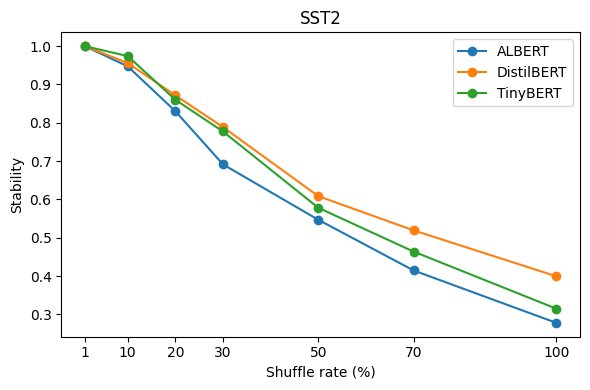

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stability_from_combined(combined_df, RATIOS, title="IMDB"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(6, 4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"] * 100, sub["corr_spearman_mean"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Shuffle rate (%)")
    plt.ylabel("Stability")
    plt.legend()
    
    # --- use RATIOS for x-ticks ---
    plt.xticks([r * 100 for r in RATIOS], [int(r * 100) for r in RATIOS])
    plt.ylim()
    plt.tight_layout()
    plt.show()

# Example usage
plot_stability_from_combined(final_results, RATIOS, title="SST2")

In [ ]:
# List of models to evaluate
MODEL_DIRS = {
    "TinyBERT": "D:/master/NLP/models/tinybert_imdb/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_imdb/final",
    "ALBERT": "D:/master/NLP/models/albert_imdb/final"
}

# --- Run all models ---
all_results = []

for model_name, model_dir in MODEL_DIRS.items():
    print(f"\n===== Running stability for {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)
    model.to(device).eval()

    stability_df = evaluate_stability(
        imdb_df,
        tokenizer,
        model,
        ratios=RATIOS,
        device=device,
    )

    # add model column
    stability_df["model"] = model_name
    stability_df.rename(columns={"ratio": "p", "mean_spearman": "corr_spearman_mean"}, inplace=True)
    all_results.append(stability_df)

# --- combine all ---
final_results = pd.concat(all_results, ignore_index=True)
print(final_results)


===== Running stability for TinyBERT =====


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]



===== Running stability for DistilBERT =====


100%|██████████| 100/100 [03:39<00:00,  2.20s/it]



===== Running stability for ALBERT =====


100%|██████████| 100/100 [07:35<00:00,  4.56s/it]

       p  corr_spearman_mean       model
0   0.01            0.966141    TinyBERT
1   0.10            0.570149    TinyBERT
2   0.20            0.466051    TinyBERT
3   0.30            0.393257    TinyBERT
4   0.50            0.326653    TinyBERT
5   0.70            0.271924    TinyBERT
6   1.00            0.195721    TinyBERT
7   0.01            0.965974  DistilBERT
8   0.10            0.624551  DistilBERT
9   0.20            0.446293  DistilBERT
10  0.30            0.370550  DistilBERT
11  0.50            0.251074  DistilBERT
12  0.70            0.191964  DistilBERT
13  1.00            0.109795  DistilBERT
14  0.01            0.963438      ALBERT
15  0.10            0.623906      ALBERT
16  0.20            0.449137      ALBERT
17  0.30            0.349704      ALBERT
18  0.50            0.228291      ALBERT
19  0.70            0.153625      ALBERT
20  1.00            0.092441      ALBERT


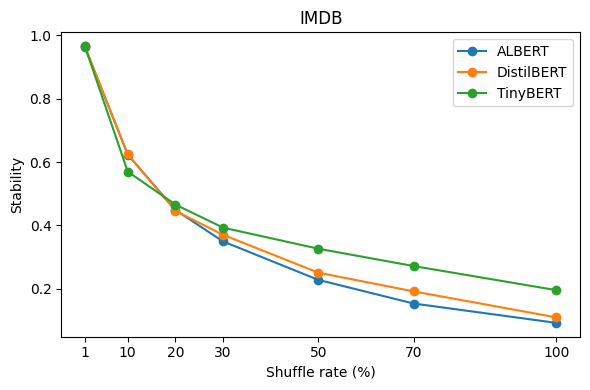

In [32]:
# Example usage
plot_stability_from_combined(final_results, RATIOS, title="IMDB")

# Comprehensiveness

In [36]:
@torch.no_grad()
def comprehensiveness_score(
    text: str,
    tokenizer,
    model,
    get_importance_fn,
    k_ratio: float = 0.2,
    device: str = "cpu",
    max_length=512
) -> float:
    """
    Compute Comprehensiveness:
    - Extract token importances using the given function (e.g. get_token_importance)
    - Delete top-k% important tokens
    - Measure drop in model confidence

    Parameters
    ----------
    text : str
        Input text
    tokenizer : HuggingFace tokenizer
    model : HuggingFace model
    get_importance_fn : callable
        Function that returns (tokens, scores)
    k_ratio : float, optional
        Ratio of top tokens to remove (default=0.2)
    device : str, optional
        "cuda" or "cpu"
    """
    # Extract importance scores
    tokens, scores = get_importance_fn(text, tokenizer, model, device=device)

    # Compute baseline confidence
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    logits = model(**inputs).logits
    probs = softmax(logits, dim=-1)
    pred = probs.argmax(dim=-1).item()
    conf_orig = probs[0, pred].item()

    # Rank tokens & delete top-k%
    seq_len = len(tokens)
    k = max(1, int(k_ratio * seq_len))

    ignore_tokens = {"[CLS]", "[SEP]"}
    valid_idxs = [i for i, tok in enumerate(tokens) if tok not in ignore_tokens]
    ranked = sorted(valid_idxs, key=lambda i: scores[i], reverse=True)
    to_remove = set(ranked[:k])

    kept_tokens = [tokens[i] for i in range(seq_len) if i not in to_remove]
    new_text = tokenizer.convert_tokens_to_string(kept_tokens)

    # Re-run model on modified text
    new_inputs = tokenizer(new_text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    new_logits = model(**new_inputs).logits
    new_probs = softmax(new_logits, dim=-1)
    conf_new = new_probs[0, pred].item()

    # Comprehensiveness = confidence drop
    return conf_orig - conf_new

In [37]:
# Run for all models
MODEL_DIRS = {
    "TinyBERT": "D:/master/NLP/models/tinybert_imdb/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_imdb/final",
    "ALBERT": "D:/master/NLP/models/albert_imdb/final"
}

all_results = []

for model_name, model_dir in MODEL_DIRS.items():
    print(f"\n===== Running Comprehensiveness for {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_dir, output_attentions=True
    ).to(device).eval()

    # For each ratio, compute average comprehensiveness across dataset
    ratio_scores = []
    for r in RATIOS:
        comp_values = []
        for text in imdb_df["texts"]:
            try:
                comp = comprehensiveness_score(
                    text=text,
                    tokenizer=tokenizer,
                    model=model,
                    get_importance_fn=get_token_importance,  # use your extractor
                    k_ratio=r,
                    device=device,
                )
                comp_values.append(comp)
            except Exception:
                continue

        mean_comp = np.nanmean(comp_values)
        ratio_scores.append({"p": r, "comp_mean": mean_comp, "model": model_name})
        print(f"Ratio={r:.2f}, Mean comp={mean_comp:.4f}")

    model_df = pd.DataFrame(ratio_scores)
    all_results.append(model_df)

# Combine results
final_comp = pd.concat(all_results, ignore_index=True)
print(final_comp)


===== Running Comprehensiveness for TinyBERT =====
Ratio=0.01, Mean comp=0.0714
Ratio=0.10, Mean comp=0.2156
Ratio=0.20, Mean comp=0.3292
Ratio=0.30, Mean comp=0.3924
Ratio=0.50, Mean comp=0.4026
Ratio=0.70, Mean comp=0.4472
Ratio=1.00, Mean comp=0.3751

===== Running Comprehensiveness for DistilBERT =====
Ratio=0.01, Mean comp=0.0398
Ratio=0.10, Mean comp=0.2512
Ratio=0.20, Mean comp=0.2934
Ratio=0.30, Mean comp=0.3504
Ratio=0.50, Mean comp=0.4487
Ratio=0.70, Mean comp=0.4682
Ratio=1.00, Mean comp=0.5136

===== Running Comprehensiveness for ALBERT =====
Ratio=0.01, Mean comp=0.0578
Ratio=0.10, Mean comp=0.3234
Ratio=0.20, Mean comp=0.3719
Ratio=0.30, Mean comp=0.4905
Ratio=0.50, Mean comp=0.5077
Ratio=0.70, Mean comp=0.5666
Ratio=1.00, Mean comp=0.3250
       p  comp_mean       model
0   0.01   0.071361    TinyBERT
1   0.10   0.215562    TinyBERT
2   0.20   0.329179    TinyBERT
3   0.30   0.392430    TinyBERT
4   0.50   0.402550    TinyBERT
5   0.70   0.447218    TinyBERT
6   1.00   

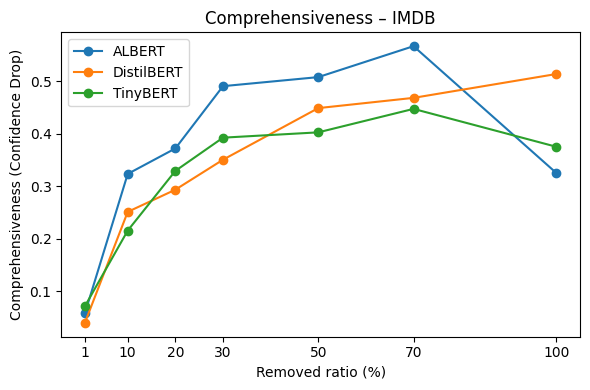

In [ ]:
def plot_comprehensiveness_from_combined(combined_df, RATIOS, title="IMDB"):
    """
    Plot Comprehensiveness (confidence drop) for multiple models.
    Expected columns: ['model', 'p', 'comp_mean']
    """
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(6, 4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"] * 100, sub["comp_mean"], marker="o", label=model)

    plt.title(f"{title}")
    plt.xlabel("Removed ratio (%)")
    plt.ylabel("Comprehensiveness")
    plt.legend()

    # --- use RATIOS for x-ticks ---
    plt.xticks([r * 100 for r in RATIOS], [int(r * 100) for r in RATIOS])
    plt.tight_layout()
    plt.show()

# Example usage:
plot_comprehensiveness_from_combined(final_comp, RATIOS, title="IMDB")


In [39]:
# Run for all models
MODEL_DIRS = {
    "TinyBERT": "D:/master/NLP/models/tinybert_sst2/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_sst2/final",
    "ALBERT": "D:/master/NLP/models/albert_sst2/final"
}

all_results = []

for model_name, model_dir in MODEL_DIRS.items():
    print(f"\n===== Running Comprehensiveness for {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_dir, output_attentions=True
    ).to(device).eval()

    # For each ratio, compute average comprehensiveness across dataset
    ratio_scores = []
    for r in RATIOS:
        comp_values = []
        for text in sst2_df["texts"]:
            try:
                comp = comprehensiveness_score(
                    text=text,
                    tokenizer=tokenizer,
                    model=model,
                    get_importance_fn=get_token_importance,  # use your extractor
                    k_ratio=r,
                    device=device,
                )
                comp_values.append(comp)
            except Exception:
                continue

        mean_comp = np.nanmean(comp_values)
        ratio_scores.append({"p": r, "comp_mean": mean_comp, "model": model_name})
        print(f"Ratio={r:.2f}, Mean comp={mean_comp:.4f}")

    model_df = pd.DataFrame(ratio_scores)
    all_results.append(model_df)

# Combine results
final_comp = pd.concat(all_results, ignore_index=True)
print(final_comp)


===== Running Comprehensiveness for TinyBERT =====
Ratio=0.01, Mean comp=0.1357
Ratio=0.10, Mean comp=0.2211
Ratio=0.20, Mean comp=0.2800
Ratio=0.30, Mean comp=0.3105
Ratio=0.50, Mean comp=0.3983
Ratio=0.70, Mean comp=0.4846
Ratio=1.00, Mean comp=0.6889

===== Running Comprehensiveness for DistilBERT =====
Ratio=0.01, Mean comp=0.2425
Ratio=0.10, Mean comp=0.2591
Ratio=0.20, Mean comp=0.3507
Ratio=0.30, Mean comp=0.3994
Ratio=0.50, Mean comp=0.4568
Ratio=0.70, Mean comp=0.5771
Ratio=1.00, Mean comp=0.5689

===== Running Comprehensiveness for ALBERT =====
Ratio=0.01, Mean comp=0.2814
Ratio=0.10, Mean comp=0.3806
Ratio=0.20, Mean comp=0.4511
Ratio=0.30, Mean comp=0.4906
Ratio=0.50, Mean comp=0.5567
Ratio=0.70, Mean comp=0.5733
Ratio=1.00, Mean comp=0.5705
       p  comp_mean       model
0   0.01   0.135724    TinyBERT
1   0.10   0.221150    TinyBERT
2   0.20   0.279995    TinyBERT
3   0.30   0.310467    TinyBERT
4   0.50   0.398329    TinyBERT
5   0.70   0.484640    TinyBERT
6   1.00   

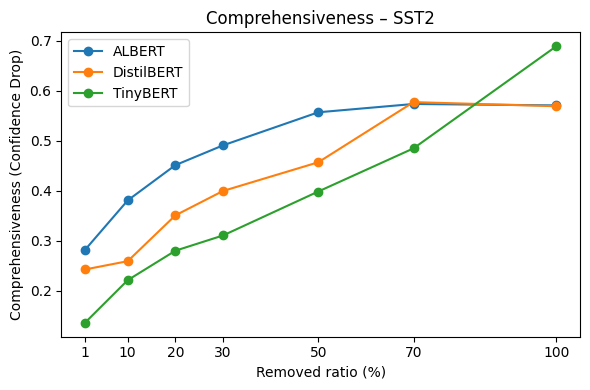

In [40]:
plot_comprehensiveness_from_combined(final_comp, RATIOS, title="SST2")


# Suffiency

In [41]:
@torch.no_grad()
def sufficiency_score(
    text: str,
    tokenizer,
    model,
    get_importance_fn,
    k_ratio: float = 0.2,
    device: str = "cpu",
    max_length = 512
) -> float:
    """
    Compute Sufficiency:
    - Extract token importances using the given function (e.g. get_token_importance)
    - Keep only the top-k% most important tokens
    - Measure drop in model confidence

    Parameters
    ----------
    text : str
        Input text
    tokenizer : HuggingFace tokenizer
    model : HuggingFace model
    get_importance_fn : callable
        Function that returns (tokens, scores)
    k_ratio : float, optional
        Ratio of top tokens to keep (default=0.2)
    device : str, optional
        "cuda" or "cpu"
    """
    # Extract importance scores
    tokens, scores = get_importance_fn(text, tokenizer, model, device=device)

    # Compute baseline confidence
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    logits = model(**inputs).logits
    probs = softmax(logits, dim=-1)
    pred = probs.argmax(dim=-1).item()
    conf_orig = probs[0, pred].item()

    # Rank tokens & KEEP only top-k%
    seq_len = len(tokens)
    k = max(1, int(k_ratio * seq_len))

    ignore_tokens = {"[CLS]", "[SEP]"}
    valid_idxs = [i for i, tok in enumerate(tokens) if tok not in ignore_tokens]
    ranked = sorted(valid_idxs, key=lambda i: scores[i], reverse=True)
    to_keep = set(ranked[:k])

    # Build new text (keep only top-k tokens)
    kept_tokens = [tokens[i] for i in range(seq_len) if i in to_keep or tokens[i] in ignore_tokens]
    new_text = tokenizer.convert_tokens_to_string(kept_tokens)

    # Re-run model on reduced text
    new_inputs = tokenizer(new_text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    new_logits = model(**new_inputs).logits
    new_probs = softmax(new_logits, dim=-1)
    conf_new = new_probs[0, pred].item()

    # Sufficiency = drop in confidence when only top-k are kept
    return conf_orig - conf_new

In [ ]:
# Run for all models
MODEL_DIRS = {
    "TinyBERT": "D:/master/NLP/models/tinybert_imdb/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_imdb/final",
    "ALBERT": "D:/master/NLP/models/albert_imdb/final"
}

all_results = []

for model_name, model_dir in MODEL_DIRS.items():
    print(f"\n===== Running Sufficiency for {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_dir, output_attentions=True
    ).to(device).eval()

    # For each ratio, compute average comprehensiveness across dataset
    ratio_scores = []
    for r in RATIOS:
        comp_values = []
        for text in imdb_df["texts"]:
            try:
                comp = sufficiency_score(
                    text=text,
                    tokenizer=tokenizer,
                    model=model,
                    get_importance_fn=get_token_importance,  # use your extractor
                    k_ratio=r,
                    device=device,
                )
                comp_values.append(comp)
            except Exception:
                continue

        suff_mean = np.nanmean(comp_values)
        ratio_scores.append({"p": r, "suff_mean": suff_mean, "model": model_name})
        print(f"Ratio={r:.2f}, Mean comp={suff_mean:.4f}")

    model_df = pd.DataFrame(ratio_scores)
    all_results.append(model_df)

# Combine results
final_suff = pd.concat(all_results, ignore_index=True)
print(final_suff)


===== Running Sufficiency for TinyBERT =====
Ratio=0.01, Mean comp=0.1180
Ratio=0.10, Mean comp=0.0424
Ratio=0.20, Mean comp=0.0256
Ratio=0.30, Mean comp=0.0242
Ratio=0.50, Mean comp=0.0261
Ratio=0.70, Mean comp=-0.0047
Ratio=1.00, Mean comp=-0.0048

===== Running Sufficiency for DistilBERT =====
Ratio=0.01, Mean comp=0.3594
Ratio=0.10, Mean comp=0.0847
Ratio=0.20, Mean comp=0.0720
Ratio=0.30, Mean comp=0.0705
Ratio=0.50, Mean comp=0.0456
Ratio=0.70, Mean comp=0.0138
Ratio=1.00, Mean comp=0.0035

===== Running Sufficiency for ALBERT =====
Ratio=0.01, Mean comp=0.2732
Ratio=0.10, Mean comp=0.0522
Ratio=0.20, Mean comp=0.0576
Ratio=0.30, Mean comp=0.0228
Ratio=0.50, Mean comp=0.0175
Ratio=0.70, Mean comp=0.0047
Ratio=1.00, Mean comp=0.0101
       p  comp_mean       model
0   0.01   0.117951    TinyBERT
1   0.10   0.042356    TinyBERT
2   0.20   0.025603    TinyBERT
3   0.30   0.024159    TinyBERT
4   0.50   0.026095    TinyBERT
5   0.70  -0.004721    TinyBERT
6   1.00  -0.004798    Tiny

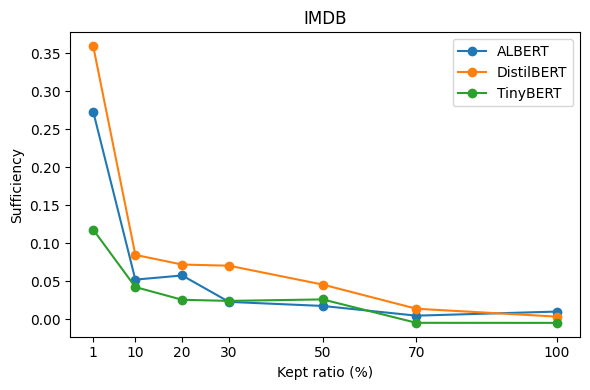

In [ ]:
def plot_sufficiency_from_combined(combined_df, RATIOS, title="IMDB"):
    """
    Plot Sufficiency (confidence retention) for multiple models.
    Expected columns: ['model', 'p', 'suff_mean']
    """
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(6, 4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"] * 100, sub["suff_mean"], marker="o", label=model)

    plt.title(f"{title}")
    plt.xlabel("Kept ratio (%)")
    plt.ylabel("Sufficiency")
    plt.legend()

    # --- use RATIOS for x-ticks ---
    plt.xticks([r * 100 for r in RATIOS], [int(r * 100) for r in RATIOS])
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sufficiency_from_combined(final_suff, RATIOS, title="IMDB")

In [47]:
# Run for all models
MODEL_DIRS = {
    "TinyBERT": "D:/master/NLP/models/tinybert_sst2/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_sst2/final",
    "ALBERT": "D:/master/NLP/models/albert_sst2/final"
}

all_results = []

for model_name, model_dir in MODEL_DIRS.items():
    print(f"\n===== Running Sufficiency for {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_dir, output_attentions=True
    ).to(device).eval()

    # For each ratio, compute average comprehensiveness across dataset
    ratio_scores = []
    for r in RATIOS:
        comp_values = []
        for text in sst2_df["texts"]:
            try:
                comp = sufficiency_score(
                    text=text,
                    tokenizer=tokenizer,
                    model=model,
                    get_importance_fn=get_token_importance,  # use your extractor
                    k_ratio=r,
                    device=device,
                )
                comp_values.append(comp)
            except Exception:
                continue

        suff_mean = np.nanmean(comp_values)
        ratio_scores.append({"p": r, "suff_mean": suff_mean, "model": model_name})
        print(f"Ratio={r:.2f}, Mean comp={suff_mean:.4f}")

    model_df = pd.DataFrame(ratio_scores)
    all_results.append(model_df)

# Combine results
final_suff = pd.concat(all_results, ignore_index=True)
print(final_suff)


===== Running Sufficiency for TinyBERT =====
Ratio=0.01, Mean comp=0.3695
Ratio=0.10, Mean comp=0.2096
Ratio=0.20, Mean comp=0.1447
Ratio=0.30, Mean comp=0.0913
Ratio=0.50, Mean comp=0.0397
Ratio=0.70, Mean comp=0.0297
Ratio=1.00, Mean comp=0.0166

===== Running Sufficiency for DistilBERT =====
Ratio=0.01, Mean comp=0.3603
Ratio=0.10, Mean comp=0.2906
Ratio=0.20, Mean comp=0.2270
Ratio=0.30, Mean comp=0.1763
Ratio=0.50, Mean comp=0.1348
Ratio=0.70, Mean comp=0.1017
Ratio=1.00, Mean comp=0.0348

===== Running Sufficiency for ALBERT =====
Ratio=0.01, Mean comp=0.5042
Ratio=0.10, Mean comp=0.4665
Ratio=0.20, Mean comp=0.4206
Ratio=0.30, Mean comp=0.3391
Ratio=0.50, Mean comp=0.2197
Ratio=0.70, Mean comp=0.1789
Ratio=1.00, Mean comp=0.1593
       p  suff_mean       model
0   0.01   0.369527    TinyBERT
1   0.10   0.209641    TinyBERT
2   0.20   0.144708    TinyBERT
3   0.30   0.091346    TinyBERT
4   0.50   0.039709    TinyBERT
5   0.70   0.029661    TinyBERT
6   1.00   0.016606    TinyBE

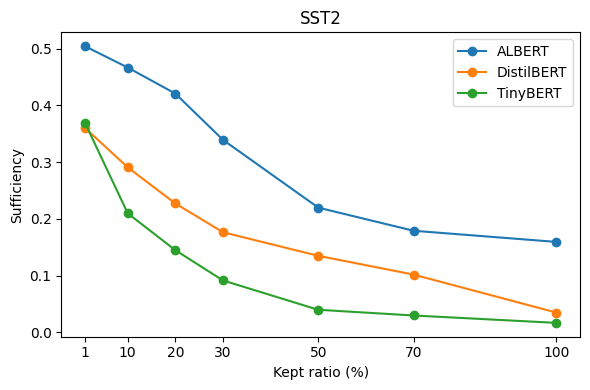

In [ ]:
plot_sufficiency_from_combined(final_suff, RATIOS, title="SST2")